# Plots for linear regression standard training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
import matplotlib.patches
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'linear_regression_standard_training'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
RISKS_FIGURE_SIZE = (2.7, 2.0)
LOSS_FIGURE_SIZE_SMALL = (2.25, 2.0)
LOSS_FIGURE_SIZE_WIDE = (3.15, 2.0)
LEGEND_FIGURE_SIZE_LARGE = (5.5, 0.55)
LEGEND_FIGURE_SIZE_SMALL = (5.5, 0.4)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs['params.data_gaussian_noise_variance'] = runs['params.data_gaussian_noise_variance'].astype(np.float)
runs = runs.sort_values(['params.data_dim', 'params.l2_lambda', 'params.data_gaussian_noise_variance'], ascending=True)
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()

Loaded 832 runs


## Plots

In [8]:
gamma_range = np.concatenate((
    np.linspace(0.01, 2.0, num=33, endpoint=False),
    np.linspace(2.0, 6.0, num=17, endpoint=True)
))
lambda_range = np.concatenate((
    np.linspace(0.0, 2.0, num=20, endpoint=False),
    np.linspace(2.0, 100.0, num=50, endpoint=True)
))
noise_variances = (0.0, 0.2)
test_attack_epsilons = (0.0, 0.4)

print(f'Plotting theoretical predictions for {len(gamma_range)} gammas, {len(lambda_range)} lambdas, {len(noise_variances)} noise variances, {len(test_attack_epsilons)} test attack epsilons')

Plotting theoretical predictions for 50 gammas, 70 lambdas, 2 noise variances, 2 test attack epsilons


In [9]:
# Calculate values
standard_risks = np.zeros((len(gamma_range), len(lambda_range), len(noise_variances), len(test_attack_epsilons)), dtype=np.float)
robust_risks = np.zeros((len(gamma_range), len(lambda_range), len(noise_variances), len(test_attack_epsilons)), dtype=np.float)
for gamma_idx, gamma in enumerate(gamma_range):
    if gamma_idx % 10 == 0 or gamma_idx + 1 == len(gamma_range):
        print(f'{gamma_idx+1}/{len(gamma_range)}: {gamma}')
    for noise_idx, noise_variance in enumerate(noise_variances):
        for epsilon_idx, test_attack_epsilon in enumerate(test_attack_epsilons):
            standard_risk, robust_risk = ir.closed_form.linear_regression_st_risks(
                l2_lambda=lambda_range,
                gamma=gamma,
                sigma_sq=noise_variance,
                epsilon_test=test_attack_epsilon
            )
            standard_risks[gamma_idx, :, noise_idx, epsilon_idx] = standard_risk
            robust_risks[gamma_idx, :, noise_idx, epsilon_idx] = robust_risk

standard_risks = np.where(np.isnan(standard_risks), np.inf, standard_risks)
robust_risks = np.where(np.isnan(robust_risks), np.inf, robust_risks)

1/50: 0.01
11/50: 0.613030303030303
21/50: 1.216060606060606
31/50: 1.819090909090909
41/50: 3.75
50/50: 6.0


### d/n vs risks plot

In [10]:
EMPIRICAL_DATA_DIMS_SHOWN = (6000, 5000, 4000, 3000, 2000, 1250, 750, 500)

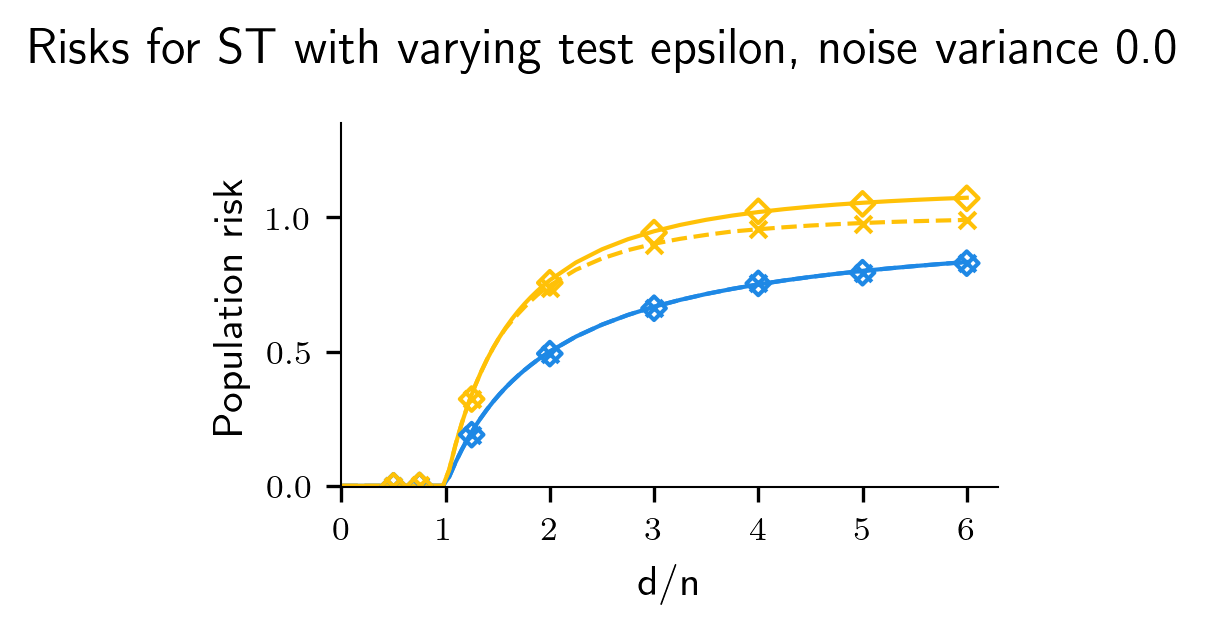

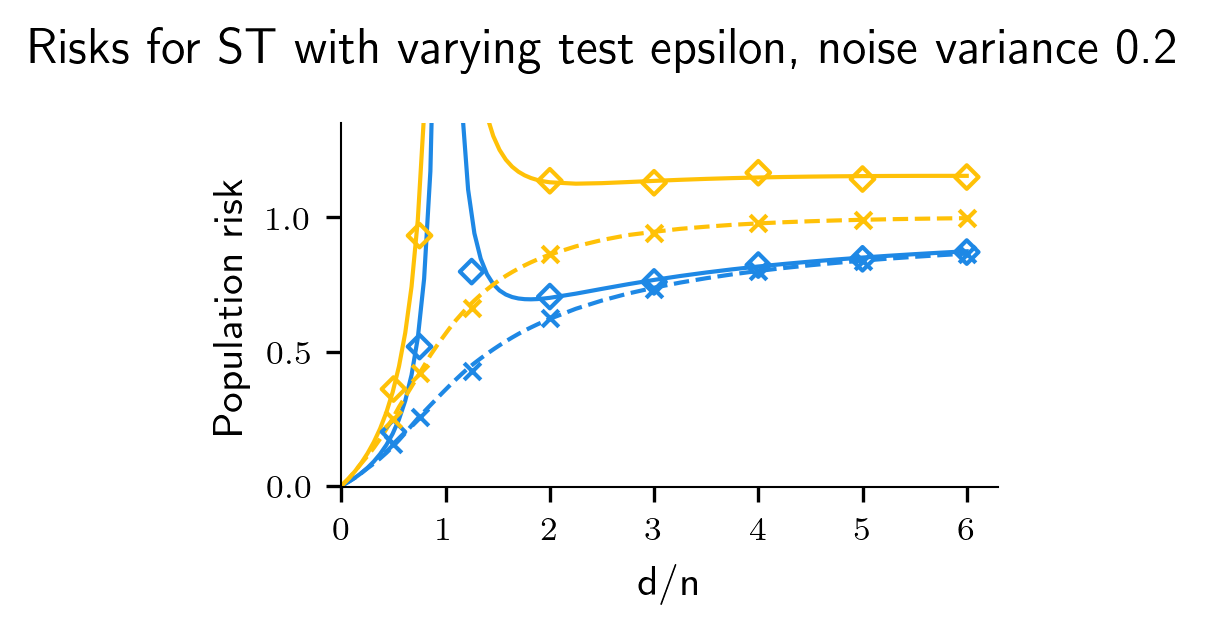

<Figure size 1650x165 with 0 Axes>

In [11]:
ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

legend_font_size = ir.plots.FONT_SIZE_SMALL_PT

num_samples, = runs['params.num_train_samples'].unique()

for noise_idx, noise_variance in enumerate(noise_variances):
    fig, ax = plt.subplots(figsize=RISKS_FIGURE_SIZE)
    
    empirical_runs = runs[runs['params.data_gaussian_noise_variance'] == noise_variance]
    # Only show some of the empirical runs to de-clutter the figure
    empirical_runs = empirical_runs[empirical_runs['params.data_dim'].isin(EMPIRICAL_DATA_DIMS_SHOWN)]
    empirical_noreg_runs = empirical_runs[empirical_runs['params.l2_lambda'] == 0.0]
    empirical_bestreg_runs = empirical_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

    for epsilon_idx, test_attack_epsilon in enumerate(test_attack_epsilons):
        risk_type = 'Robust' if test_attack_epsilon > 0 else 'Standard'
        empirical_metric = 'metrics.true_robust_risk' if test_attack_epsilon > 0 else 'metrics.true_std_risk'
        noreg_label = 'interpolating'
        bestreg_label = 'regularized (opt.)'

        # Theoretical predictions
        ax.plot(
            gamma_range,
            robust_risks[:, 0, noise_idx, epsilon_idx],
            label=f'{risk_type}, {noreg_label}',
            c=f'C{epsilon_idx}',
            ls='-',
            zorder=1
        )
        
        ax.plot(
            gamma_range,
            np.min(robust_risks[:, :, noise_idx, epsilon_idx], axis=1),
            label=f'{risk_type}, {bestreg_label}',
            c=f'C{epsilon_idx}',
            ls='--',
            zorder=1
        )

        # Empirical predictions
        ax.scatter(
            empirical_noreg_runs['params.data_dim'] / float(num_samples),
            empirical_noreg_runs[empirical_metric],
            label=f'{risk_type}, {noreg_label}',
            edgecolors=f'C{epsilon_idx}',
            facecolors='none',
            marker='D',
            zorder=2,
            **ir.plots.matplotlib_scatter_marker_settings()
        )
        ax.scatter(
            empirical_bestreg_runs.index / float(num_samples),
            empirical_bestreg_runs[empirical_metric],
            label=f'{risk_type}, {bestreg_label}',
            c=f'C{epsilon_idx}',
            marker='x',
            zorder=2,
            **ir.plots.matplotlib_scatter_marker_settings()
        )    

    ax.set_xlabel('d/n')
    ax.set_ylabel('Population risk')
    ax.set_ylim(-0.005, 1.35)
    ax.set_xlim(-0.005, 6.3)
    ax.set_xticks(tuple(range(6 + 1)))
    
    if SHOW_TITLES:
        fig.suptitle(f'Risks for ST with varying test epsilon, noise variance {noise_variance}')

    export_fig(fig, f'standard_training_noise_{noise_variance}.pdf')
    plt.show()

# Legend
theoretical_handles_labels = tuple(zip(*filter(
    lambda handle_label: isinstance(handle_label[0], matplotlib.lines.Line2D),
    zip(*ax.get_legend_handles_labels())
)))
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE_LARGE)

handles, labels = theoretical_handles_labels
legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'linreg_standard_training_legend.pdf')


### Risk decomposition

In [12]:
lambda_range_decomp = np.concatenate((
    np.linspace(0.0, 1.5, num=2000, endpoint=False),
    np.linspace(1.5, 6.0, num=2000, endpoint=False),
    np.linspace(6.0, 30.0, num=1000, endpoint=False),
    np.linspace(30.0, 100.0, num=1000, endpoint=True)
))


In [13]:
gamma_range_shown = np.asarray((2.0, 2.8, 4.5))
gamma_range_full = np.concatenate((
    gamma_range_shown,
    np.linspace(0.01, 1.5, num=50, endpoint=False),
    np.linspace(1.5, 5.0, num=50, endpoint=False),
    np.linspace(5.0, 10.0, num=50, endpoint=False),
    np.linspace(10.0, 100.0, num=50, endpoint=True)
))
parallel_diff_norms_sq = np.zeros((len(gamma_range_full), len(lambda_range_decomp)), dtype=np.float)
orthogonal_norms_sq = np.zeros((len(gamma_range_full), len(lambda_range_decomp)), dtype=np.float)
for gamma_idx, gamma in enumerate(gamma_range_full):
    if gamma_idx % 100 == 0 or gamma_idx == len(gamma_range_full) - 1:
        print(f'{gamma_idx+1}/{len(gamma_range_full)}: {gamma}')
    parallel_diff_norm_sq, orthogonal_norm_sq = ir.closed_form.linear_regression_st_noiseless_risk_decomposition(
        l2_lambda=lambda_range_decomp,
        gamma=gamma
    )
    parallel_diff_norms_sq[gamma_idx] = parallel_diff_norm_sq
    orthogonal_norms_sq[gamma_idx] = orthogonal_norm_sq


1/203: 2.0
101/203: 4.790000000000001
201/203: 96.3265306122449
203/203: 100.0


In [14]:
robust_risks_decomp = np.zeros((len(test_attack_epsilons), len(gamma_range_full), len(lambda_range_decomp)), dtype=np.float)
for epsilon_idx, test_attack_epsilon in enumerate(test_attack_epsilons):
    robust_risks_decomp[epsilon_idx] = parallel_diff_norms_sq \
        + (1.0 + np.square(test_attack_epsilon)) * orthogonal_norms_sq \
        + 2.0 * np.sqrt(2.0 / np.pi) * test_attack_epsilon * np.sqrt(orthogonal_norms_sq) * np.sqrt(parallel_diff_norms_sq + orthogonal_norms_sq)

opt_lambda_indices = np.argmin(robust_risks_decomp, axis=2)

all_lambda_arrow_indices = (700, 900, 700)

robust_epsilon_idx = 1
assert len(test_attack_epsilons) == 2 and test_attack_epsilons[robust_epsilon_idx] > 0

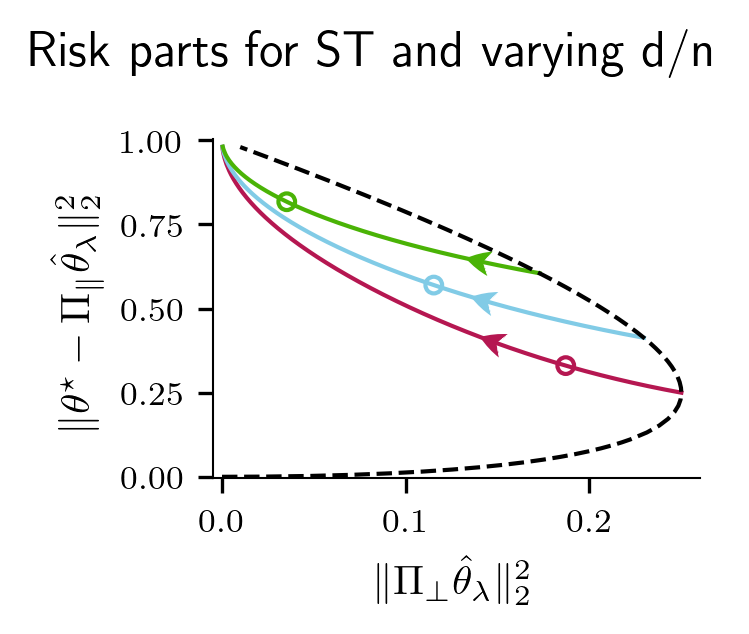

<Figure size 1650x120 with 0 Axes>

In [15]:
arrow_properties = {
    'arrowstyle': 'fancy',
    'edgecolor': 'none',
    'mutation_scale': 1.5 * ir.plots.FONT_SIZE_PT,
    'rasterized': False
}
opt_lambda_marker = 'o'

fig, ax = plt.subplots(figsize=LOSS_FIGURE_SIZE_SMALL)

for gamma_idx, gamma in enumerate(gamma_range_shown):
    current_color = f'C{gamma_idx + 2}'
    
    # General line
    current_xs = orthogonal_norms_sq[gamma_idx]
    current_ys = parallel_diff_norms_sq[gamma_idx]
    ax.plot(
        current_xs,
        current_ys,
        label=fr'$\gamma = {gamma}$',
        c=current_color,
        ls='-',
        zorder=1
    )
    
    # Arrows
    all_lambda_arrow_idx = all_lambda_arrow_indices[gamma_idx]
    all_lambda_arrow_tail_idx = all_lambda_arrow_indices[gamma_idx] - 1
    arrow_properties['facecolor'] = current_color
    ax.annotate(
        '',
        xy=(current_xs[all_lambda_arrow_idx], current_ys[all_lambda_arrow_idx]),
        xytext=(current_xs[all_lambda_arrow_tail_idx], current_ys[all_lambda_arrow_tail_idx]),
        arrowprops=arrow_properties
    )

    # Optimal lambda for robust risk
    opt_lambda_idx = opt_lambda_indices[robust_epsilon_idx, gamma_idx]
    plt.scatter(
        orthogonal_norms_sq[gamma_idx, opt_lambda_idx],
        parallel_diff_norms_sq[gamma_idx, opt_lambda_idx],
        edgecolors=current_color,
        facecolors='none',
        marker=opt_lambda_marker,
        zorder=3,
        **ir.plots.matplotlib_scatter_marker_settings()
    )

# lambda = 0 line
sorted_gamma_indices = np.argsort(gamma_range_full)
plt.plot(
    orthogonal_norms_sq[sorted_gamma_indices, 0],
    parallel_diff_norms_sq[sorted_gamma_indices, 0],
    label=f'$\lambda = 0$',
    c='black',
    ls='dashed',
    zorder=2
)

ax.set_xlabel(r'$\| \Pi_{\perp} \hat{\theta}_\lambda \|_2^2$')
ax.set_ylabel(r'$\| \theta^\star - \Pi_{\parallel} \hat{\theta}_\lambda \|_2^2$')
ax.set_ylim(-0.005, 1.005)
ax.set_xlim(-0.005, 0.26)

if SHOW_TITLES:
    fig.suptitle(f'Risk parts for ST and varying d/n')

export_fig(fig, f'linreg_gammacurves.pdf')
plt.show()

# Legend
legend_fig_risks = plt.figure(figsize=LEGEND_FIGURE_SIZE_SMALL)
handles, labels = ax.get_legend_handles_labels()
proxy_patch = matplotlib.patches.Patch(color='none')
opt_marker_patch = matplotlib.lines.Line2D(
    [], [],
    color='black',
    linestyle='none',
    marker=opt_lambda_marker,
    label=r'$\lambda_{opt}$',
    markersize=4,
    markeredgewidth=1,
    markerfacecolor='none'
)

handles = [proxy_patch] + handles[:-1] + [proxy_patch] + handles[-1:] + [opt_marker_patch]
labels = [r'$\lambda \uparrow$:'] + labels[:-1] + [''] + labels[-1:] + [opt_marker_patch.get_label()]
legend_fig_risks.legend(
    handles,
    labels,
    loc='center',
    ncol=len(handles),
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig_risks, f'linreg_theory_legend.pdf')


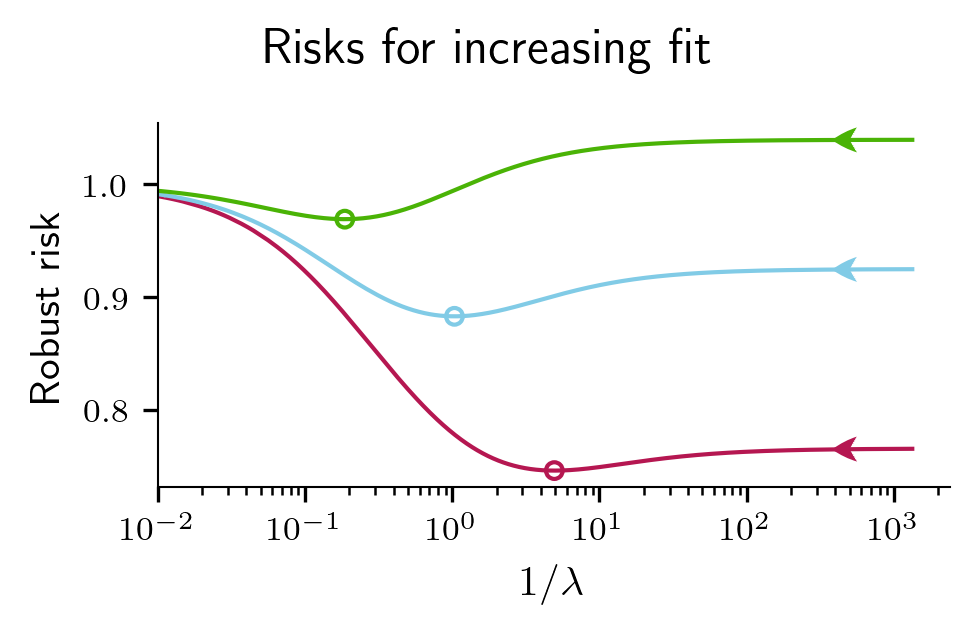

In [16]:
arrow_indices_wideplot = (5995, 5995, 5995)

fig, ax = plt.subplots(figsize=LOSS_FIGURE_SIZE_WIDE)

for gamma_idx, gamma in enumerate(gamma_range_shown):
    current_color = f'C{gamma_idx + 2}'
    
    # General line
    with np.errstate(divide='ignore'):
        current_xs = 1.0 / lambda_range_decomp  # div by zero is expected for lambda = 0
    current_ys = robust_risks_decomp[robust_epsilon_idx, gamma_idx]
    current_xs = np.flip(current_xs)
    current_xs = current_xs
    current_ys = np.flip(current_ys)
    ax.plot(
        current_xs,
        current_ys,
        label=fr'$\gamma = {gamma}$',
        c=current_color,
        ls='-',
        zorder=1
    )
    
    # Arrows
    arrow_idx = arrow_indices_wideplot[gamma_idx]
    arrow_tail_idx = arrow_idx + 1
    arrow_properties['facecolor'] = current_color
    ax.annotate(
        '',
        xy=(current_xs[arrow_idx], current_ys[arrow_idx]),
        xytext=(current_xs[arrow_tail_idx], current_ys[arrow_tail_idx]),
        arrowprops=arrow_properties
    )

    # Optimal lambda for robust risk
    opt_lambda_idx = len(lambda_range_decomp) - 1 - opt_lambda_indices[robust_epsilon_idx, gamma_idx]
    ax.scatter(
        current_xs[opt_lambda_idx],
        current_ys[opt_lambda_idx],
        edgecolors=current_color,
        facecolors='none',
        marker='o',
        zorder=3,
        **ir.plots.matplotlib_scatter_marker_settings()
    )

ax.set_xlabel(r'$1 / \lambda$')
ax.set_ylabel(r'Robust risk')
ax.set_xscale('log')
ax.set_xlim(left=np.min(current_xs))

if SHOW_TITLES:
    fig.suptitle(f'Risks for increasing fit')

export_fig(fig, f'linreg_increasing_fit.pdf')
plt.show()
